In [1]:
### Figure 3E for the PERISCOPE manuscript. ###
### Script by Meraj Ramezani(mramezan@broadinstitute.org) ###
# Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap.umap_ as umap
import pathlib
import os
from pathlib import Path
import hdbscan

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
np.random.seed(42)

In [2]:
# set data input folder
# download files described in README.md to this folder
data_input_folder = "../../"

# set output folder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
# Import the Hela DMEM gene level profiles
cp257_dmem_df = pd.read_csv(os.path.join(data_input_folder,'20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS_plate_level_gene_aggregated.csv.gz'))
cp257_dmem_df = cp257_dmem_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
# Import the Hela DMEM hits from the hit calling process then subset the gene level profiles for all hits 
comp_spef_hits = pd.read_csv('../../Fig3_A_B/cp257_dmem_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
comp_spef_hits = comp_spef_hits.rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')
whole_cell_hits = pd.read_csv('../../Fig3_A_B/cp257_dmem_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
whole_cell_hits = whole_cell_hits.rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')
whole_cell_hit_list = list(whole_cell_hits.index)

hit_list = list(comp_spef_hits.index) + list(whole_cell_hits.index)
df_hits = cp257_dmem_df.loc[hit_list]
df_hits


,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_HuMoment_1,...,Nuclei_Texture_SumVariance_DAPI_Painting_10_02_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_Mito_5_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_03_256,Nuclei_Texture_SumVariance_Phalloidin_5_01_256,Nuclei_Texture_SumVariance_WGA_10_01_256,Nuclei_Texture_SumVariance_WGA_10_03_256,Nuclei_Texture_SumVariance_WGA_5_01_256
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A4GALT,-0.003687,-0.001517,-0.024211,-0.002230,-0.000985,0.048217,-0.247624,-0.385445,-0.181542,-0.310485,...,-0.205460,-0.124003,-0.061160,-0.064534,-0.158805,-0.175165,-0.100943,-0.116820,-0.127088,-0.208700
AADAT,0.010149,-0.050984,-0.000033,-0.011308,0.000147,-0.390320,0.192267,0.127596,0.360045,-0.037015,...,0.035560,0.096781,0.002351,0.014290,-0.047730,-0.055333,-0.027467,-0.030975,-0.054734,-0.066406
AAGAB,0.001373,-0.073191,0.005038,-0.008009,-0.000422,-0.110842,0.408275,0.010436,0.014049,-0.013480,...,-0.364305,-0.374600,-0.045733,-0.048909,-0.093886,-0.073781,-0.127453,-0.269980,0.009450,-0.024553
AARSD1,0.011580,-0.099327,-0.017418,0.022201,0.004731,-0.048940,-0.060862,-0.170685,-0.057970,-0.051002,...,-0.251240,-0.230710,-0.123475,-0.036832,-0.078641,-0.171565,-0.146525,-0.317805,-0.210240,-0.273045
AASDHPPT,0.010061,-0.008188,0.016220,-0.005553,0.001298,-0.359410,-0.452070,-0.113907,0.367390,-0.194975,...,-0.160485,-0.184115,-0.156485,-0.030092,-0.156475,-0.236350,-0.165520,-0.378370,-0.270330,-0.201435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,0.002234,0.023157,0.012874,0.013057,0.000447,-0.268155,-0.032118,-0.136975,0.203412,-0.126557,...,-0.166314,-0.231420,-0.150015,-0.063093,-0.058868,-0.073555,-0.056141,-0.257935,-0.285295,-0.359115
ZPR1,0.000413,-0.015735,-0.015433,0.001812,-0.000215,-0.551765,-0.001942,0.403800,0.569805,-0.217560,...,0.242875,0.536345,0.335195,0.045955,-0.013645,0.059679,-0.001273,0.092637,-0.032070,-0.005467
ZSWIM8,0.008489,0.287793,-0.001380,0.012269,0.002484,-0.070610,-0.190660,-0.032445,-0.026930,-0.222235,...,-0.109120,0.011316,0.010509,0.018169,-0.121815,-0.111510,-0.119964,-0.045433,0.318355,-0.044189


In [4]:
# Perform principal componenet analysis and select components representing 70% of variation in data & print the variation of components selected by PCA
pca = PCA()
pca.fit(df_hits)
x = list(pca.explained_variance_ratio_)
y = [sum(x[:i+1]) for i in range(len(x))]
y[74]

0.6970615609575871

In [5]:
# Perform principal componenet analysis and select components representing 70% of variation in data
pca = PCA(n_components=75)
df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
df_hits_pca

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
Metadata_Foci_Barcode_MatchedTo_GeneCode,,,,,,,,,,,,,,,,,,,,,
A4GALT,-6.605163,-1.486661,0.561727,-0.022946,0.622741,-2.035755,-0.250695,0.516637,0.338742,2.321812,...,-0.610757,0.451225,0.601338,-1.140013,0.323304,0.310659,0.484745,0.521115,-0.637057,0.150167
AADAT,3.239729,-1.917427,0.186562,-0.996945,-1.036008,-0.700663,-0.213684,-0.425547,1.522795,-0.706344,...,-0.027846,0.142570,0.017151,0.089809,-0.263171,0.043921,-0.432511,-0.122799,-0.066875,0.071013
AAGAB,-0.385966,-1.976094,-5.683792,2.657807,0.671442,0.633168,-1.643910,1.591522,-1.805018,0.027086,...,-0.215929,0.045398,-0.192914,0.074793,-0.026572,-0.317236,0.099670,0.416744,0.104874,0.043773
AARSD1,-5.526339,-0.919157,2.124758,-2.127335,0.229689,-0.141629,-0.516680,-0.376504,1.147600,-1.265887,...,-0.112737,-0.195279,0.654953,0.473429,-1.051350,-0.238794,0.160674,-0.652941,0.345996,-0.085130
AASDHPPT,-2.887035,6.138479,-3.761078,-2.051477,2.239069,-0.403315,0.859499,1.875794,1.166338,0.710942,...,0.258615,-0.308182,0.092764,-0.198322,0.469870,-0.750164,-0.178136,0.426419,-0.088348,0.161994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,-3.235321,4.953116,2.249152,0.526933,-1.208167,-0.871635,-0.932720,-0.394653,1.937773,-1.215697,...,0.107944,-0.304131,-0.117251,-0.105307,-0.543801,-0.315124,0.446679,0.286391,0.313458,0.549728
ZPR1,13.454316,4.411361,2.171386,-3.069164,1.210735,3.703342,-1.852048,-0.632047,1.377511,-0.167631,...,0.209814,0.014797,0.082087,-0.422471,-0.327726,-0.336469,0.000313,0.051794,-0.184682,-0.093711
ZSWIM8,5.038060,-1.446766,0.365135,-6.078490,3.641857,-0.789370,0.532543,0.657733,-0.117205,0.291434,...,-0.750817,0.001406,-0.673489,0.119396,1.082481,-0.417882,0.310932,0.073045,0.622941,-0.126582


In [6]:
# Perform UMAP dimentinality reduction to project data into a 2 dimentional plane 

clusterable_embedding = umap.UMAP(
    n_neighbors=4,
    min_dist=0.04,
    n_components=2,
    random_state=43,
    metric = 'cosine',
).fit_transform(df_hits_pca)

In [7]:
# Manually label highlighted hits  
overal_labels = [hit_list.index(i) if i in whole_cell_hit_list else -1 for i in hit_list ]
other_labels = [hit_list.index(i) if i not in whole_cell_hit_list else -1 for i in hit_list ]
highlight_list = [
    # GOCC_MITOCHONDRIAL_MATRIX
    'MRPL37','MRPL35','MRPL36','PARS2','PDHB','POLG','TARS2','DAP3','MCAT','METTL17','MRPL19','MRPL21','MRPL49','MRPS17','PDHA1','RPUSD3','MRPL33','ELAC2',
    'FASTKD5','MRPL16','MRPL41','MRPL57','NDUFA9','POLDIP2','SSBP1','SUPV3L1','DHX30','ERAL1','MRPL46','NDUFS2','DDX28','MARS2','MRPL11','MRPL14','MRPS35',
    'NDUFB8','PPTC7','MIPEP','MRPS28','MRPL34','MRPL43','MRPS33','TEFM','MRPL28','NDUFS3','COQ5','GADD45GIP1','GLUD1','HSD17B10','MRPS11','MRPL55','MRPS26',
    'MTG2','PDP2','MRPL32','MRPL42','MRPS22','MRPS27','TFB2M','TUFM','TSFM','HARS2','MRPS16','MRPS21','MRPS6','PDSS2','CS','MRPL12','MRPL45','MRPL52',
    'MRPL9','POLG2','MRPS18C','NDUFA10','MDH2','MRPL17','MRPL20','MRPL38','MRPL53','MRPL54','MRPS12','MRPS14','MRPS2','MRPS34','MRPS9','MTERF4','NARS2',
    'NDUFS1','RARS2','REXO2','TFAM','TRUB2','YARS2','NDUFS8','MRPL48','MRPL51','MRPL15','MRPL2','MRPL19','MCAT','MRPL22','OXA1L','LONP1','CLPX','GFM1',
    'LARS2','POLRMT','SARS2','PTCD1','MRPL4','SCO2','MRPL44','DLAT','MRPS10','RPUSD4','NDUFAF7','PDSS1','MRPL18','MRPS15','MRPL39','MRPS7','FECH','MRPL13',
    'MRPL3','PITRM1','GFM2',
    # GOBP_DNA_REPLICATION
    'MCM3','RAD51','RFC3','RTEL1','TIPIN','TRAIP','SLX4','CDK2','GINS1','GINS2','GINS4','POLD2','POLD3','PRIM2','RPA3','SIN3A','RFC2','MCM6','LIG1','CDK2AP1','SSRP1',
    'ATAD5','MMS22L','POLE2','DUT','MCM7','POLE','POLA1','GINS3','MCM5','RFC5','MCM2','TONSL','POLD1'
    # GOBP_RIBOSOME_BIOGENESIS
    'BOP1','NMD3','NOP2','DDX51','DDX54','EIF6','GNL2','GTPBP4','ISG20L2','LSG1','MAK16','NIP7','NOL9','NOP16','NVL','PAK1IP1','PES1','PWP1','RPF2','RRP1','RSL1D1',
    'URB1','URB2','WDR12','WDR55','WDR74','RPS6','RPS8','AATF','DDX10','DDX47','DHX37','DKC1','EMG1','FBL','FCF1','KRI1','KRR1','LTV1','MPHOSPH10','NAT10','NIFK',
    'NOB1','NOC4L','NOL6','NOP14','NOP58','PDCD11','POP4','RCL1','RPP30','RPS14','RPS16','RPS19','RPS21','RPS24','RPS25','RPS5','SRFBP1','TBL3','TSR2','UTP18','UTP3',
    'UTP6','WDR3','WDR43','ZNHIT3','DIMT1','POP5', 'RIOK2','RRP7A','WDR36','WDR46','FTSJ3','MYBBP1A','RSL24D1','SDAD1','GTF3A','LAS1L','WDR18','PWP2','RRP12',
    'TRMT112','UTP23','UTP15','IMP3','ESF1','EXOSC8','RPS17','EXOSC9','NOL10','XRCC5','RIOK1','EXOSC3','IMP4','DDX21','BMS1',
    # GOBP_MANNOSYLATION 
    'ALG1L','ALG12','ALG3','ALG9','DPM1','DPM2',
    # GOCC_PROTON_TRANSPORTING_TWO_SECTOR_ATPASE_COMPLEX (lysosome acidification)
    'RNASEK','ATP6AP1','ATP6V0B','ATP6V0C','ATP6V0D1','ATP6V1A','ATP6V1B2','ATP6V1C1','ATP6V1D','ATP6V1E1','ATP6V1F','ATP6V1G1','ATP6V1H','ATP6AP2',
    # GOBP_GOLGI_VESICLE_TRANSPORT
    'COG5','SCFD1','SEC22B','ARL1','BNIP1','COG6','COG7','SYS1','TRAPPC2','TRAPPC8','NSF','STX5','TRAPPC11','TRAPPC3','TRAPPC4','COG1','COG2','COG3','COG4','COG8',
    'NAPG','TRAPPC1','TRAPPC5','USO1','YKT6',
    # GOBP_ARP2_3_COMPLEX_MEDIATED_ACTIN_NUCLEATION
    'ARPC4','ARPC3','ACTR3','ACTR2','ARPC2',
    # GOBP_PROTEIN_N_LINKED_GLYCOSYLATION
    'SRD5A3', 'ALG1', 'ALG14', 'ALG2', 'DAD1', 'DDOST', 'DPAGT1', 'RPN2', 'TMEM258',
    # GOBP_ENZYME_LINKED_RECEPTOR_PROTEIN_SIGNALING_PATHWAY
    'CHRD','EFNB1','EID2','IGF2R','JAK2','PRKD2','RBPMS2','STMN1','CEACAM1','GNAI2','NTRK2','SPRED1','CAV2','HIVEP1','TTK','CRB2','IL17RD','TMEM204','PIN1','ZEB2',
    'NUP62','PDCD4','NODAL',
    # GOBP_CELLULAR_RESPIRATION
    'SDHD','SOD2','DLST','SDHA','SDHB','OGDH','SUCLG1','DLD','MRPS36',
    # GOBP_REGULATION_OF_GTPASE_ACTIVITY
    'PTK2','TMED2','CRKL','RAPGEF1','EIF2S1','FERMT2','RABGAP1','RTN4R','LIMS1',    
    ]

highlight_labels = [hit_list.index(i) if i in highlight_list else -1 for i in hit_list ]
len(overal_labels)-other_labels.count(-1)

2332

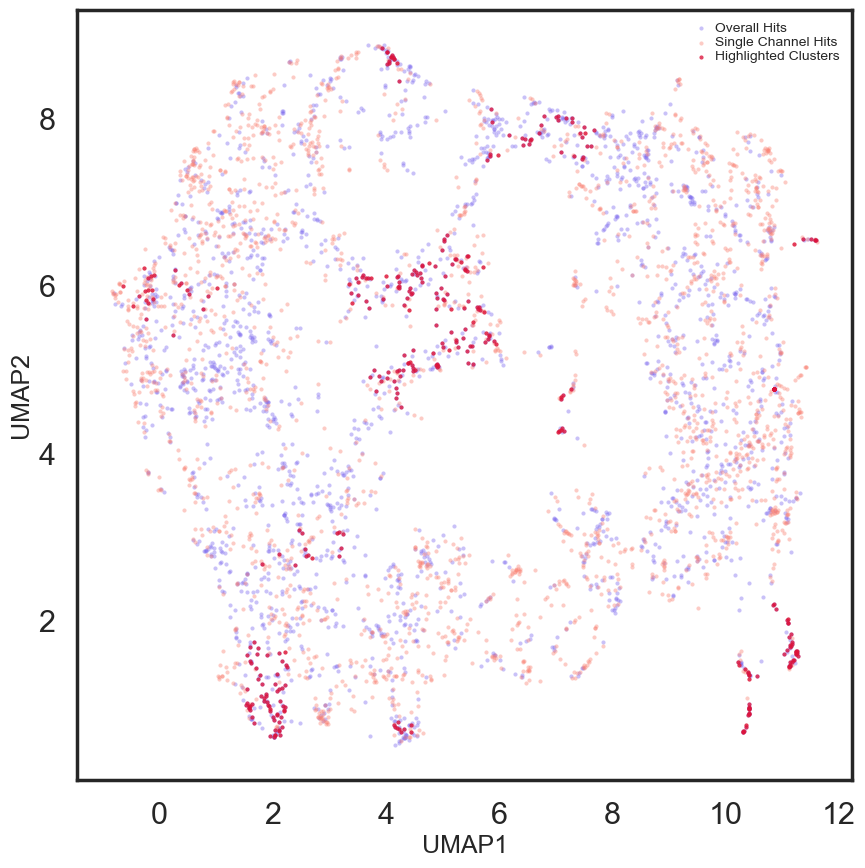

In [8]:
plt.figure(figsize=(10, 10))

plt.scatter(clusterable_embedding[overal_labels, 0],
            clusterable_embedding[overal_labels, 1],
            c='mediumslateblue',#firebrick
            s=1,
            alpha=0.4,
           # cmap='Spectral'
           );

plt.scatter(clusterable_embedding[other_labels, 0],
            clusterable_embedding[other_labels, 1],
            c='salmon',#royalblue burlywood
            s=1,
            alpha=0.4,
           # cmap='Spectral'
           );

plt.scatter(clusterable_embedding[highlight_labels, 0],
            clusterable_embedding[highlight_labels, 1],
            c='crimson',#royalblue burlywood
            s=1,
            alpha=0.8,
           # cmap='Spectral'
           );

plt.xlabel('UMAP1',fontsize=18)
plt.ylabel('UMAP2',fontsize=18)
plt.legend(labels=['Overall Hits','Single Channel Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)# 

file_name = 'Fig3_E_Hela_dmem_UMAP_clustering.png'
output_file = pathlib.Path(f"{file_name}")
plt.savefig(os.path.join(output_folder,output_file),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')